In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install matplotlib
# !pip install seaborn
# !pip install yfinance

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
from IPython.display import clear_output

class RealTimeTradingBot:
    def __init__(self, stocks, initial_capital=10000):
        self.stocks = stocks
        self.capital = initial_capital
        self.portfolio = {}
        self.trading_history = []
        self.csv_filename = "stock_data.csv"

    def save_to_csv(self, symbol, data):
        """Save stock data to a CSV file."""
        try:
            data['Symbol'] = symbol
            if not pd.io.common.file_exists(self.csv_filename):
                data.to_csv(self.csv_filename, index=False)
            else:
                data.to_csv(self.csv_filename, mode='a', header=False, index=False)
        except Exception as e:
            print(f"Error saving data for {symbol}: {e}")

    def get_stock_data(self, symbol):
        """Fetch stock data and calculate key metrics."""
        try:
            stock = yf.Ticker(symbol)
            history = stock.history(period="1d", interval="1m").reset_index()
            self.save_to_csv(symbol, history[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']])

            # Calculate moving average for noise reduction
            moving_average = history['Close'].rolling(window=5).mean().iloc[-1]

            return {
                'current_price': history['Close'].iloc[-1],
                'mean_price': history['Close'].mean(),
                'moving_average': moving_average,
                'recent_trend': self._calculate_trend(history['Close'])
            }
        except Exception as e:
            print(f"Error fetching {symbol} data: {e}")
            return None

    def _calculate_trend(self, prices):
        """Calculate trend using linear regression."""
        x = np.arange(len(prices))
        slope, _ = np.polyfit(x, prices, 1)
        return slope

    def predict_action(self, stock_data):
        """Predict trading action based on stock data."""
        current_price = stock_data['current_price']
        mean_price = stock_data['mean_price']
        moving_average = stock_data['moving_average']
        trend = stock_data['recent_trend']

        # Predictive logic
        if current_price < moving_average * 0.95 and trend > 0:
            return "BUY"
        elif current_price > moving_average * 1.05 and trend < 0:
            return "SELL"
        return "HOLD"

    def execute_trade(self, symbol, action, price):
        """Simulate trade execution."""
        if action == "BUY" and self.capital > price:
            shares = int(self.capital * 0.2 // price)
            if shares > 0:
                self.portfolio[symbol] = self.portfolio.get(symbol, 0) + shares
                self.capital -= shares * price
                self.trading_history.append({'action': 'BUY', 'symbol': symbol, 'shares': shares, 'price': price})

        elif action == "SELL" and symbol in self.portfolio:
            shares = self.portfolio.pop(symbol, 0)
            self.capital += shares * price
            self.trading_history.append({'action': 'SELL', 'symbol': symbol, 'shares': shares, 'price': price})

    def track_and_trade(self, duration=300, interval=5):
        """Real-time tracking and trading with clean outputs."""
        start_time = time.time()
        while time.time() - start_time < duration:
            clear_output(wait=True)  # Clean output for better readability
            print(f"TRADING BOT REAL-TIME ANALYSIS (Refresh every {interval}s)")
            print(f"Current Capital: ${self.capital:.2f}")
            print(f"Portfolio: {self.portfolio}")
            print("-" * 40)

            for symbol in self.stocks:
                stock_data = self.get_stock_data(symbol)
                if stock_data:
                    action = self.predict_action(stock_data)
                    self.execute_trade(symbol, action, stock_data['current_price'])
                    print(f"{symbol}: Price: ${stock_data['current_price']:.2f}, Action: {action}")
                    print(f"Moving Avg: ${stock_data['moving_average']:.2f}, Trend: {stock_data['recent_trend']:.5f}")
                    print("-" * 40)

            time.sleep(interval)  # Adjust refresh rate here

        print("Trading session completed.")
        print(f"Final Portfolio: {self.portfolio}")
        print(f"Remaining Capital: ${self.capital:.2f}")

# Usage
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
bot = RealTimeTradingBot(stocks)
bot.track_and_trade(duration=300, interval=5)  # 5-second refresh for 5 minutes


TRADING BOT REAL-TIME ANALYSIS (Refresh every 5s)
Current Capital: $10000.00
Portfolio: {}
----------------------------------------
AAPL: Price: $227.55, Action: HOLD
Moving Avg: $227.77, Trend: -0.06733
----------------------------------------
GOOGL: Price: $175.49, Action: HOLD
Moving Avg: $175.40, Trend: -0.06362
----------------------------------------
MSFT: Price: $413.23, Action: HOLD
Moving Avg: $413.39, Trend: -0.11097
----------------------------------------
AMZN: Price: $200.98, Action: HOLD
Moving Avg: $201.03, Trend: -0.04044
----------------------------------------


<ipython-input-3-9c136aba4268>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Symbol'] = symbol
<ipython-input-3-9c136aba4268>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Symbol'] = symbol
<ipython-input-3-9c136aba4268>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Trading session completed.
Final Portfolio: {}
Remaining Capital: $10000.00


Available stocks in the dataset: ['AAPL' 'GOOGL' 'MSFT' 'AMZN']


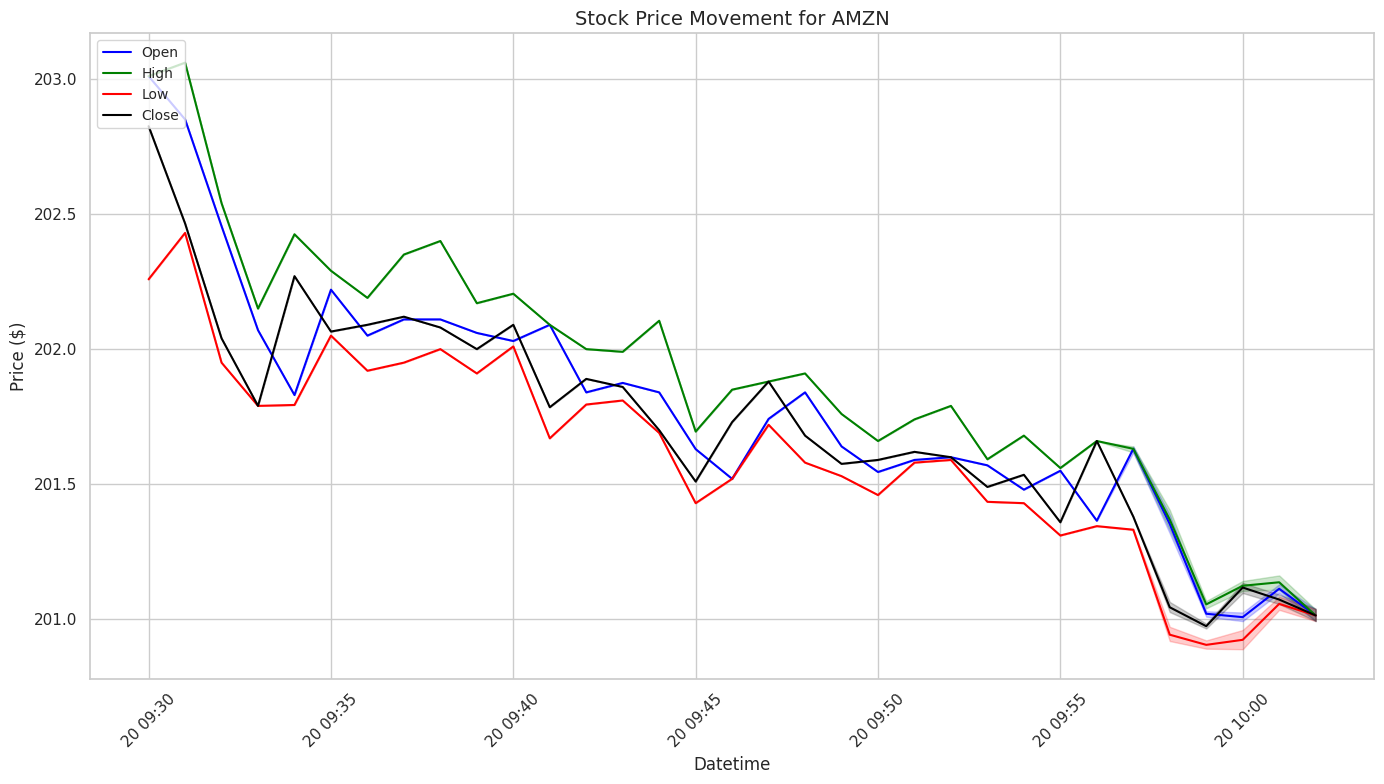

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the stock data from the CSV file
stock_csv_filename = "stock_data.csv"
stock_df = pd.read_csv(stock_csv_filename)

# Convert 'Datetime' column to datetime type for better plotting
stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime'])

# Plotting function for a line graph
def plot_line_graph(stock_symbol):
    """
    Plot line graph for Open, High, Low, Close prices for a given stock symbol.
    """
    # Filter data for the selected stock symbol
    stock_data = stock_df[stock_df['Symbol'] == stock_symbol]

    if stock_data.empty:
        print(f"No data available for {stock_symbol}. Please check the symbol.")
        return

    # Set Seaborn style
    sns.set_theme(style="whitegrid")

    # Create a figure for the line plot
    plt.figure(figsize=(14, 8))

    # Plot Open, High, Low, Close prices
    sns.lineplot(x='Datetime', y='Open', data=stock_data, label='Open', color='blue')
    sns.lineplot(x='Datetime', y='High', data=stock_data, label='High', color='green')
    sns.lineplot(x='Datetime', y='Low', data=stock_data, label='Low', color='red')
    sns.lineplot(x='Datetime', y='Close', data=stock_data, label='Close', color='black')

    # Set labels and title
    plt.xlabel('Datetime', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.title(f"Stock Price Movement for {stock_symbol}", fontsize=14)

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend(loc='upper left', fontsize=10)

    # Display the plot
    plt.tight_layout()
    plt.show()

# List of unique stock symbols in the dataset
stock_symbols = stock_df['Symbol'].unique()
print("Available stocks in the dataset:", stock_symbols)

# Example: Visualize data for a specific stock symbol
# Replace 'AAPL' with the symbol you want to visualize
plot_line_graph('AMZN')
